In [ ]:
# !git clone https://github.com/huggingface/transformers.git
# %cd transformers
# !pip install -e .
#%cd /content

In [1]:
!pip install transformers datasets evaluate albumentations torchinfo torchmetrics accelerate timm wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.4 MB/s eta 0:00:00


In [3]:
import datasets, transformers
from datasets import load_dataset
from transformers import AutoProcessor, AutoModelForUniversalSegmentation, OneFormerForUniversalSegmentation
from transformers import Trainer, TrainingArguments
import evaluate
import accelerate
import albumentations as A
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchinfo, torchmetrics
import wandb
from huggingface_hub import notebook_login

from pathlib import Path
import requests
import zipfile
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
notebook_login()

In [6]:
####
#@title Load Rail19small with splits
####
railsem_ds = load_dataset("BhavanaMalla/railsem19-semantic-split355")
railsem_ds

Generating train split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'semantic_mask_label', 'json'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['image', 'semantic_mask_label', 'json'],
        num_rows: 500
    })
    test: Dataset({
        features: ['image', 'semantic_mask_label', 'json'],
        num_rows: 500
    })
})

In [ ]:
railsem_ds["train"].features

{'image': Image(decode=True, id=None),
 'semantic_mask_label': Image(decode=True, id=None),
 'json': {'frame': Value(dtype='string', id=None),
  'imgHeight': Value(dtype='int64', id=None),
  'imgWidth': Value(dtype='int64', id=None),
  'objects': [{'boundingbox': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
    'label': Value(dtype='string', id=None),
    'polygon': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
    'polyline': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
    'polyline-pair': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None)}]}}

In [ ]:
#sample image
image = railsem_ds["train"][0]["image"]
mask = railsem_ds["train"][0]["semantic_mask_label"]
sample_json = railsem_ds["train"][0]["json"]

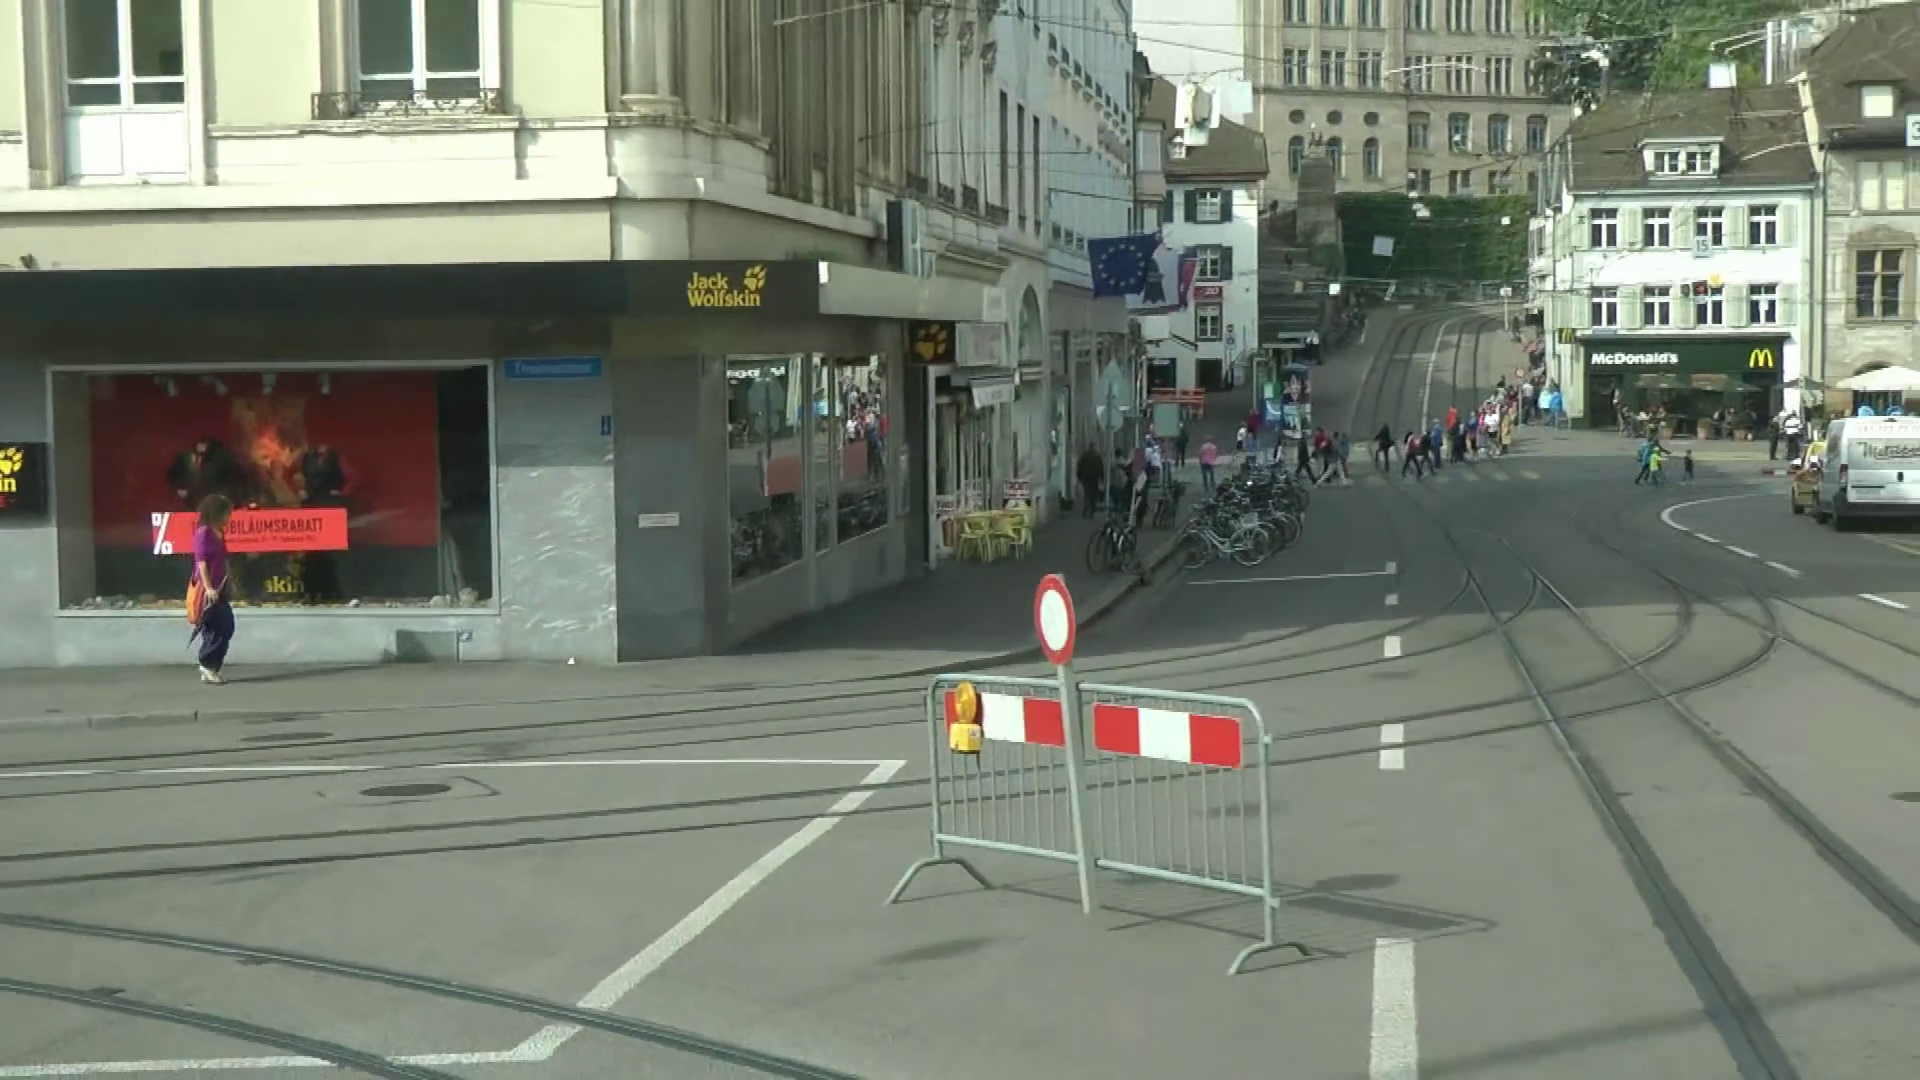

In [ ]:
image

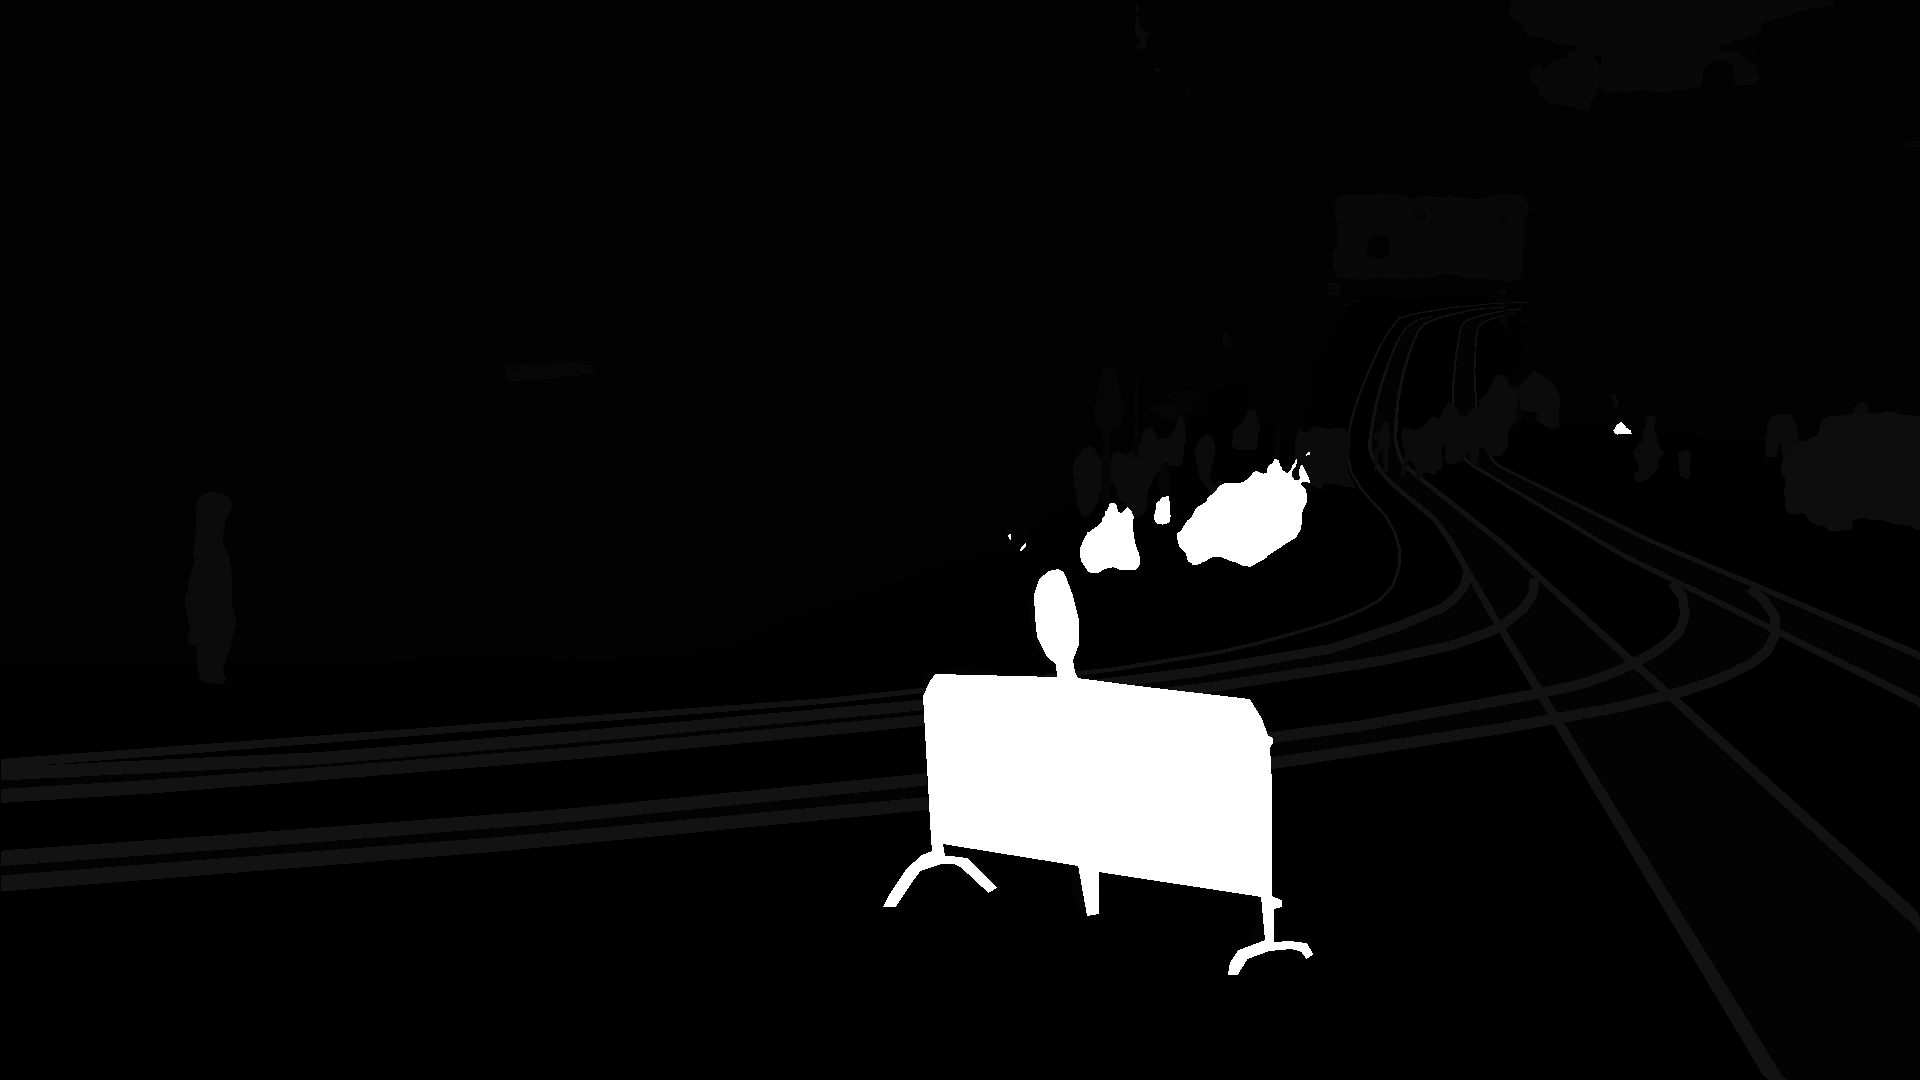

In [ ]:
mask

In [ ]:
sample_json.keys(), len(sample_json["objects"]), sample_json["objects"][0]

(dict_keys(['frame', 'imgHeight', 'imgWidth', 'objects']),
 13,
 {'boundingbox': [1029, 576, 1078, 656],
  'label': 'track-sign-front',
  'polygon': None,
  'polyline': None,
  'polyline-pair': None})

In [ ]:
#Convert the sample image and pixel wise mask to array
image = np.array(image)
mask = np.array(mask)
image.shape, image.dtype, mask.shape, mask.dtype, np.unique(mask)

((1080, 1920, 3),
 dtype('uint8'),
 (1080, 1920),
 dtype('uint8'),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  11,  13,  18,
        255], dtype=uint8))

In [ ]:
####
#@title Create id2label for rail19sem dataset with 19 classes  from json
####

from huggingface_hub import hf_hub_download

config_file = hf_hub_download(repo_id="BhavanaMalla/railsem19-semantic-split355",
                filename="rs19-config.json",
                repo_type="dataset",
                local_dir="/content")

with open(config_file, "r") as f:
    config_json = json.load(f)

print(config_json)
labels = config_json["labels"]

extract_labels = []
readable_labels = []
color_palette = []
for label in labels:
    extract_labels.append(label["name"])
    color_palette.append(label["color"])
    readable_labels.append(label["readable"])

id2label = {idx: label for idx, label in enumerate(extract_labels)}
label2id = {label: idx for idx, label in enumerate(extract_labels)}
labels = extract_labels

id2label, label2id, color_palette, readable_labels, labels

{'labels': [{'color': [128, 64, 128], 'evaluate': True, 'instances': False, 'name': 'road', 'readable': 'Road'}, {'color': [244, 35, 232], 'evaluate': True, 'instances': False, 'name': 'sidewalk', 'readable': 'Sidewalk and train platforms'}, {'color': [70, 70, 70], 'evaluate': True, 'instances': False, 'name': 'construction', 'readable': 'Construction (includes CS wall label)'}, {'color': [192, 0, 128], 'evaluate': True, 'instances': False, 'name': 'tram-track', 'readable': 'Tram Track (between two rails used for driving on)'}, {'color': [190, 153, 153], 'evaluate': True, 'instances': False, 'name': 'fence', 'readable': 'Fence'}, {'color': [153, 153, 153], 'evaluate': True, 'instances': False, 'name': 'pole', 'readable': 'Pole'}, {'color': [250, 170, 30], 'evaluate': True, 'instances': False, 'name': 'traffic-light', 'readable': 'Traffic Light'}, {'color': [220, 220, 0], 'evaluate': True, 'instances': False, 'name': 'traffic-sign', 'readable': 'Traffic Sign'}, {'color': [107, 142, 35],

({0: 'road',
  1: 'sidewalk',
  2: 'construction',
  3: 'tram-track',
  4: 'fence',
  5: 'pole',
  6: 'traffic-light',
  7: 'traffic-sign',
  8: 'vegetation',
  9: 'terrain',
  10: 'sky',
  11: 'human',
  12: 'rail-track',
  13: 'car',
  14: 'truck',
  15: 'trackbed',
  16: 'on-rails',
  17: 'rail-raised',
  18: 'rail-embedded'},
 {'road': 0,
  'sidewalk': 1,
  'construction': 2,
  'tram-track': 3,
  'fence': 4,
  'pole': 5,
  'traffic-light': 6,
  'traffic-sign': 7,
  'vegetation': 8,
  'terrain': 9,
  'sky': 10,
  'human': 11,
  'rail-track': 12,
  'car': 13,
  'truck': 14,
  'trackbed': 15,
  'on-rails': 16,
  'rail-raised': 17,
  'rail-embedded': 18},
 [[128, 64, 128],
  [244, 35, 232],
  [70, 70, 70],
  [192, 0, 128],
  [190, 153, 153],
  [153, 153, 153],
  [250, 170, 30],
  [220, 220, 0],
  [107, 142, 35],
  [152, 251, 152],
  [70, 130, 180],
  [220, 20, 60],
  [230, 150, 140],
  [0, 0, 142],
  [0, 0, 70],
  [90, 40, 40],
  [0, 80, 100],
  [0, 254, 254],
  [0, 68, 63]],
 ['Road',

In [ ]:
####
#@title Load the pretrained model and processor from "coco-swin" checkpoint. note: change the processor and apply transforms
####

checkpoint = "shi-labs/oneformer_ade20k_swin_large"
checkpoint = "shi-labs/oneformer_ade20k_dinat_large"
checkpoint = "shi-labs/oneformer_ade20k_swin_tiny"

oneformer_coco_swin = AutoModelForUniversalSegmentation.from_pretrained(checkpoint, is_training=True)
coco_swin_processor = AutoProcessor.from_pretrained(checkpoint)

Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_coco_swin_large and are newly initialized: ['model.text_mapper.text_encoder.transformer.layers.5.self_attn.out_proj.bias', 'model.text_mapper.text_encoder.transformer.layers.5.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.1.self_attn.out_proj.weight', 'model.text_mapper.text_encoder.transformer.layers.0.self_attn.out_proj.weight', 'model.text_mapper.text_encoder.transformer.layers.4.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.1.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.1.self_attn.in_proj_bias', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.transformer.layers.0.self_attn.in_proj_weight', 'model.text_mapper.text_encoder.transformer.layers.2.mlp.fc2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.tra

In [ ]:
oneformer_coco_swin.config

In [ ]:
coco_swin_processor.attributes

['image_processor', 'tokenizer']

In [ ]:
coco_swin_processor.image_processor

In [ ]:
coco_swin_processor.tokenizer

In [ ]:
####
#@title Create custom dataset
####

class CustomDataset(Dataset):
    def __init__(self, dataset, transforms=None):
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, semantic_mask = self.dataset[idx]["image"], self.dataset[idx]["semantic_mask_label"]
        semantic_mask = np.array(semantic_mask)
        original_image = np.array(image)
        target_mask = np.array(semantic_mask)

        if self.transforms:
            transformed = self.transforms(image=original_image, mask=target_mask)
            image, semantic_mask = transformed["image"], transformed["mask"]
            image = image.transpose(2, 0, 1)

        return image, semantic_mask, original_image, target_mask

In [ ]:
#set the num_text attribute of the image processor.
coco_swin_processor.image_processor.num_text = oneformer_coco_swin.config.num_queries - oneformer_coco_swin.config.text_encoder_n_ctx

In [ ]:
#Tranforms
#ADE20k
MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255
#IMAGENET
# MEAN = np.array([0.485, 0.456, 0.406])
# STD = np.array([0.229, 0.224, 0.225])

train_transform = A.Compose([
    A.LongestMaxSize(max_size=1333),
    A.RandomCrop(width=512, height=512),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=MEAN, std=STD),
])

val_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=MEAN, std=STD),
])

test_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=MEAN, std=STD),
])

#instantiate the datasets
train_dataset = CustomDataset(railsem_ds["train"], train_transform)
val_dataset = CustomDataset(railsem_ds["validation"], val_transform)
test_dataset = CustomDataset(railsem_ds["test"], test_transform)

In [ ]:
# #testing our dataset
import torch

example = train_dataset[0]
type(example), example

In [ ]:
#coco_swin_processor.tokenizer.batch_decode(example["text_inputs"])

In [ ]:
#coco_swin_processor.tokenizer.batch_decode(example["task_inputs"])

In [ ]:
#collate_fn - this is used when using trainer
# def collate_fn(batch): #List[Dict]
#     batch_dict = {}
#     pixel_values = torch.stack([example["pixel_values"] for example in batch])
#     pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
#     class_labels = [example["class_labels"] for example in batch]
#     mask_labels = [example["mask_labels"] for example in batch]
#     text_inputs = torch.stack([example["text_inputs"] for example in batch])
#     task_inputs = torch.stack([example["task_inputs"] for example in batch])
#     batch_dict.update({"pixel_values": pixel_values,
#                        "pixel_mask": pixel_mask,
#                        "class_labels": class_labels,
#                        "mask_labels": mask_labels,
#                        "text_inputs": text_inputs,
#                        "task_inputs": task_inputs})
#     return batch_dict

In [ ]:
def collate_fn(batch):

    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]

    batch = coco_swin_processor(images,
                                segmentation_maps=segmentation_maps,
                                task_inputs=["semantic"] * len(images),
                                return_tensors="pt")
    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]
    return batch

In [ ]:
#dataloaders
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=2,
    shuffle=True,
    pin_memory=True,
    collate_fn=collate_fn
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=2,
    shuffle=False,
    # pin_memory=True,
    collate_fn=collate_fn
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=2,
    shuffle=False,
    pin_memory=True,
    collate_fn=collate_fn
)

NameError: name 'DataLoader' is not defined

**padding the images having different number of objects in dataloader using collate function**
- https://discuss.pytorch.org/t/dataloader-gives-stack-expects-each-tensor-to-be-equal-size-due-to-different-image-has-different-objects-number/91941/7

- https://discuss.pytorch.org/t/runtimeerror-stack-expects-each-tensor-to-be-equal-size-but-got-3-224-224-at-entry-0-and-3-224-336-at-entry-3/87211/10

In [ ]:
#test the dataloader
batch = next(iter(val_dataloader))
#print(batch)

for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape) #sometime we get [9, 749, 1333] at entry 0 and [14, 749, 1333] at entry 1, so use collate fn to stack them separately
    else:
        print(k, v[0].shape, v[1].shape)

In [ ]:
####
#@title Pytorch evaluation with pretrained model for railsem19 with all inputs to the model
####
from torch.optim import AdamW
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
oneformer_coco_swin.to(device)

#optimizer = AdamW(params=oneformer_coco_swin.parameters(), lr=5e-5)

metric = evaluate.load("mean_iou")


#oneformer_coco_swin.train()
oneformer_coco_swin.eval()

# oneformer_coco_swin.model.is_training = False #only for infernce

running_loss = 0.0
num_samples = 0.0
for epoch in range(1):
    #for idx, batch in enumerate(tqdm(train_dataloader)):
    for idx, batch in enumerate(tqdm(val_dataloader)):

        #optimizer.zero_grad()

        batch_dict = {
            "pixel_values": batch["pixel_values"].to(device),
            "mask_labels":  [labels.to(device) for labels in batch["mask_labels"]],
            "class_labels" : [labels.to(device) for labels in batch["class_labels"]],
            "pixel_mask" : batch["pixel_mask"].to(device),
            "text_inputs" : batch["text_inputs"].to(device),
            "task_inputs" : batch["task_inputs"].to(device),
        }
        batch_dict = {k: v.to(device) if isinstance(v, torch.Tensor) else [x.to(device) for x in v] for k, v in batch_dict.items()}

        ##train forward pass
        #train_outputs = model(**batch_dict)

        # train_loss = train_outputs.loss
        # print("Training Loss:", train_loss.item())
        # train_loss.backward()
        # batch_size = batch["pixel_values"].size(0)
        # running_loss += train_loss.item()
        num_samples += batch_size
        # if idx % 100 == 0:
        #     print("Train Loss:", running_loss / num_samples)

        ## Optimization
        # optimizer.step()

        #eval forward pass
        with torch.inference_mode():
            eval_outputs = oneformer_coco_swin(**batch_dict)

        eval_loss = eval_outputs.loss
        print("Eval Loss:", eval_loss.item())
        if num_samples > 100:
            break
        #eval metric

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Eval Loss: 173.0341033935547
Eval Loss: 168.6762237548828
Eval Loss: 158.1794891357422
Eval Loss: 149.55307006835938
Eval Loss: 182.8726043701172
Eval Loss: 169.6125030517578
Eval Loss: 172.47000122070312
Eval Loss: 152.83653259277344
Eval Loss: 165.6436767578125
Eval Loss: 153.72789001464844
Eval Loss: 165.4858856201172
Eval Loss: 148.35531616210938
Eval Loss: 194.3036346435547
Eval Loss: 177.72335815429688
Eval Loss: 159.17044067382812
Eval Loss: 171.46768188476562
Eval Loss: 159.38954162597656
Eval Loss: 168.04702758789062
Eval Loss: 169.12716674804688
Eval Loss: 170.7845458984375
Eval Loss: 170.1869354248047
Eval Loss: 144.5128936767578
Eval Loss: 147.10069274902344
Eval Loss: 166.74142456054688
Eval Loss: 162.28573608398438
Eval Loss: 150.4091796875
Eval Loss: 160.3585205078125
Eval Loss: 147.14642333984375
Eval Loss: 170.50987243652344
Eval Loss: 134.77406311035156
Eval Loss: 166.12203979492188
Eval Loss: 175.96661376953125
Eval Loss: 167.4954071044922
Eval Loss: 153.398727416992

KeyboardInterrupt: 

In [ ]:
####
#@title Pytorch evaluation with pretrained model for railsem19 with just 3 inputs and with mean iou metric
####
from torch.optim import AdamW
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
oneformer_coco_swin.to(device)

metric = evaluate.load("mean_iou")
model_results = {"eval_loss": [],
                 "miou": []}

oneformer_coco_swin.model.is_training = False

oneformer_coco_swin.eval()

running_loss = 0.0
num_samples = 0.0
for epoch in range(1):
    for idx, batch in enumerate(tqdm(val_dataloader)):

        batch_dict = {
            "pixel_values": batch["pixel_values"].to(device),
            # "mask_labels":  [labels.to(device) for labels in batch["mask_labels"]],
            # "class_labels" : [labels.to(device) for labels in batch["class_labels"]],
            "pixel_mask" : batch["pixel_mask"].to(device),
            # "text_inputs" : batch["text_inputs"].to(device),
            "task_inputs" : batch["task_inputs"].to(device),
        }
        batch_dict = {k: v.to(device) if isinstance(v, torch.Tensor) else [x.to(device) for x in v] for k, v in batch_dict.items()}

        #eval forward pass - #no need to send mask labels, class labels, text_inputs to the model when inferring - otherwise contrastive loss is triggered and text input will be none when inferring in non training mode
        with torch.inference_mode():
            eval_outputs = oneformer_coco_swin(pixel_values=batch_dict["pixel_values"],
                                               pixel_mask=batch_dict["pixel_mask"],
                                               task_inputs=batch_dict["task_inputs"]
                                               )

        #print(eval_outputs.keys()) #dict_keys(['class_queries_logits', 'masks_queries_logits', 'auxiliary_predictions', 'encoder_hidden_states', 'pixel_decoder_hidden_states', 'transformer_decoder_hidden_states', 'transformer_decoder_object_queries', 'transformer_decoder_contrastive_queries', 'transformer_decoder_mask_predictions', 'transformer_decoder_class_predictions', 'transformer_decoder_auxiliary_predictions', 'task_token', 'attentions'])
        # eval_loss = eval_outputs.loss
        # print("Eval Loss:", eval_loss.item())
        # running_loss += eval_loss.item()

        #Post process segmentation
        original_images = batch["original_images"]
        target_sizes = [(img.shape[0], img.shape[1]) for img in original_images]
        predicted_segmentation_maps = coco_swin_processor.post_process_semantic_segmentation(eval_outputs,
                                                                                             target_sizes=target_sizes)
        #eval metrics
        # get ground truth segmentation maps
        ground_truth_segmentation_maps = batch["original_segmentation_maps"]
        metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)

        batch_size = batch["pixel_values"].size(0)
        num_samples += batch_size

    mean_iou_per_epoch = metric.compute(num_labels=len(id2label), ignore_index=255)
    #mean_iou_per_epoch = metric.compute(num_labels=len(id2labels), ignore_index=255)["mean_iou"]
    # eval_loss_per_epoch = running_loss / num_samples
    # model_results["eval_loss"].append(eval_loss_per_epoch)
    model_results["miou"].append(mean_iou_per_epoch)
    print("Mean IoU:", mean_iou_per_epoch["mean_iou"])


  0%|          | 0/500 [00:00<?, ?it/s]

odict_keys(['class_queries_logits', 'masks_queries_logits', 'auxiliary_predictions', 'encoder_hidden_states', 'pixel_decoder_hidden_states', 'transformer_decoder_hidden_states', 'transformer_decoder_object_queries', 'transformer_decoder_contrastive_queries', 'transformer_decoder_mask_predictions', 'transformer_decoder_class_predictions', 'transformer_decoder_auxiliary_predictions', 'task_token', 'attentions'])
odict_keys(['class_queries_logits', 'masks_queries_logits', 'auxiliary_predictions', 'encoder_hidden_states', 'pixel_decoder_hidden_states', 'transformer_decoder_hidden_states', 'transformer_decoder_object_queries', 'transformer_decoder_contrastive_queries', 'transformer_decoder_mask_predictions', 'transformer_decoder_class_predictions', 'transformer_decoder_auxiliary_predictions', 'task_token', 'attentions'])
odict_keys(['class_queries_logits', 'masks_queries_logits', 'auxiliary_predictions', 'encoder_hidden_states', 'pixel_decoder_hidden_states', 'transformer_decoder_hidden_sta

KeyboardInterrupt: 

In [ ]:
####
#@title Pytorch Finetuning with both train data and eval data and metrics
####
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import datasets, transformers
from datasets import load_dataset
from transformers import AutoProcessor, AutoModelForUniversalSegmentation, OneFormerForUniversalSegmentation
from transformers import Trainer, TrainingArguments
import evaluate
import accelerate
import albumentations as A
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchinfo, torchmetrics
import wandb
from huggingface_hub import notebook_login
import json
import numpy as np

from torch.optim import AdamW
from tqdm.auto import tqdm
from huggingface_hub import hf_hub_download

#Dataset Loading
railsem_ds = load_dataset("BhavanaMalla/railsem19-semantic-split355")

#Labels
config_file = hf_hub_download(repo_id="BhavanaMalla/railsem19-semantic-split355",
                filename="rs19-config.json",
                repo_type="dataset",
                local_dir="/content")

with open(config_file, "r") as f:
    config_json = json.load(f)

json_labels = config_json["labels"]

extract_labels = []
readable_labels = []
color_palette = []
for label in json_labels:
    extract_labels.append(label["name"])
    color_palette.append(label["color"])
    readable_labels.append(label["readable"])

id2label = {idx: label for idx, label in enumerate(extract_labels)}
label2id = {label: idx for idx, label in enumerate(extract_labels)}
labels = extract_labels

#custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataset, transforms=None):
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, semantic_mask = self.dataset[idx]["image"], self.dataset[idx]["semantic_mask_label"]
        semantic_mask = np.array(semantic_mask)
        original_image = np.array(image)
        target_mask = np.array(semantic_mask)

        if self.transforms:
            transformed = self.transforms(image=original_image, mask=target_mask)
            image, semantic_mask = transformed["image"], transformed["mask"]
            image = image.transpose(2, 0, 1)

        return image, semantic_mask, original_image, target_mask

Generating train split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

rs19-config.json:   0%|          | 0.00/5.28k [00:00<?, ?B/s]

In [ ]:
#model config
checkpoint = "shi-labs/oneformer_coco_swin_large"
#checkpoint = "shi-labs/oneformer_ade20k_swin_tiny"

oneformer_coco_swin = AutoModelForUniversalSegmentation.from_pretrained(checkpoint,
                                                                        is_training=True,
                                                                        id2label=id2label,
                                                                        ignore_mismatched_sizes=True)
#processor
coco_swin_processor = AutoProcessor.from_pretrained(checkpoint,
                                                    do_reduce_labels=False,
                                                    do_normalize=False,
                                                    do_rescale=False,
                                                    do_resize=False,)
coco_swin_processor.image_processor.num_text = oneformer_coco_swin.config.num_queries - oneformer_coco_swin.config.text_encoder_n_ctx

#Tranforms
#ADE20k
MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255
#IMAGENET
# MEAN = np.array([0.485, 0.456, 0.406])
# STD = np.array([0.229, 0.224, 0.225])

train_transform = A.Compose([
    A.LongestMaxSize(max_size=1333),
    A.RandomCrop(width=512, height=512),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=MEAN, std=STD),
])

val_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=MEAN, std=STD),
])

test_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=MEAN, std=STD),
])


#datasets
train_dataset = CustomDataset(railsem_ds["train"], train_transform)
val_dataset = CustomDataset(railsem_ds["validation"], val_transform)
test_dataset = CustomDataset(railsem_ds["test"], test_transform)

#collate_fn
def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]

    batch = coco_swin_processor(images,
                                segmentation_maps=segmentation_maps,
                                task_inputs=["semantic"] * len(images),
                                return_tensors="pt")
    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]
    return batch

#Dataloaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

#Training
device = "cuda" if torch.cuda.is_available() else "cpu"

oneformer_coco_swin.to(device)

optimizer = AdamW(params=oneformer_coco_swin.parameters(), lr=5e-5)

metric = evaluate.load("mean_iou")

model_results = {
    "train_loss": [],
    "eval_loss": [],
    "miou": []}

#Training Loop
running_loss = 0.0
num_samples = 0.0
num_samples_eval = 0.0
for epoch in range(1):
    oneformer_coco_swin.train()
    for idx, batch in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        batch_dict = {
            "pixel_values": batch["pixel_values"].to(device),
            "mask_labels":  [labels.to(device) for labels in batch["mask_labels"]],
            "class_labels" : [labels.to(device) for labels in batch["class_labels"]],
            "pixel_mask" : batch["pixel_mask"].to(device),
            "text_inputs" : batch["text_inputs"].to(device),
            "task_inputs" : batch["task_inputs"].to(device),
        }
        batch_dict = {k: v.to(device) if isinstance(v, torch.Tensor) else [x.to(device) for x in v] for k, v in batch_dict.items()}

        #train forward pass
        outputs = oneformer_coco_swin(**batch_dict)
        train_loss = outputs.loss
        running_loss += train_loss.item()

        batch_size = batch["pixel_values"].size(0)
        num_samples += batch_size

        print(f"Train Loss: {running_loss / num_samples}")
        train_loss.backward()
        optimizer.step()

    train_loss_per_epoch = running_loss / num_samples
    model_results["train_loss"].append(train_loss_per_epoch)
    break

    oneformer_coco_swin.eval()
    for idx, batch in enumerate(tqdm(val_dataloader)):
        #eval forward pass
        with torch.inference_mode():
            eval_outputs = oneformer_coco_swin(pixel_values=batch_dict["pixel_values"],
                                               pixel_mask=batch_dict["pixel_mask"],
                                               task_inputs=batch_dict["task_inputs"]
                                               )
        print(eval_outputs.keys())

        #Post process segmentation
        original_images = batch["original_images"]
        target_sizes = [(img.shape[0], img.shape[1]) for img in original_images]
        predicted_segmentation_maps = coco_swin_processor.post_process_semantic_segmentation(eval_outputs,
                                                                                             target_sizes=target_sizes)
        #eval metrics
        # get ground truth segmentation maps
        ground_truth_segmentation_maps = batch["original_segmentation_maps"]
        metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)

        batch_size = batch["pixel_values"].size(0)
        num_samples_eval += batch_size

    mean_iou_per_epoch = metric.compute(num_labels=len(id2label), ignore_index=255)
    model_results["miou"].append(mean_iou_per_epoch)
    print("Mean IoU:", mean_iou_per_epoch["mean_iou"])


config.json:   0%|          | 0.00/82.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/879M [00:00<?, ?B/s]

Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_coco_swin_large and are newly initialized: ['model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.1.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.self_attn.in_proj_bias', 'model.text_mapper.text_encoder.transformer.layers.5.self_attn.out_proj.weight', 'model.text_mapper.text_encoder.transformer.layers.0.self_attn.out_proj.bias', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.3.mlp.fc2.weight', 'model.text_mapper.text_encoder.transformer.layers.3.self_attn.in_proj_weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.4.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.1.layer_norm1.bias', 'model.text_mapper.text_encode

preprocessor_config.json:   0%|          | 0.00/6.82k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/oneformer/image_processing_oneformer.py:426: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


coco_panoptic.json:   0%|          | 0.00/5.85k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


OutOfMemoryError: CUDA out of memory. Tried to allocate 286.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 223.06 MiB is free. Process 3003 has 14.53 GiB memory in use. Of the allocated memory 14.13 GiB is allocated by PyTorch, and 270.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
####
#@title Finetuning with Trainer
####
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import datasets, transformers
from datasets import load_dataset
from transformers import AutoProcessor, AutoModelForUniversalSegmentation, OneFormerForUniversalSegmentation
from transformers import Trainer, TrainingArguments
import evaluate
import accelerate
import albumentations as A
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchinfo, torchmetrics
import wandb
from huggingface_hub import notebook_login
import json
import numpy as np

from torch.optim import AdamW
from tqdm.auto import tqdm
from huggingface_hub import hf_hub_download

#Loading dataset
railsem_ds = load_dataset("BhavanaMalla/railsem19-semantic-split355")

#Label creation
config_file = hf_hub_download(repo_id="BhavanaMalla/railsem19-semantic-split355",
                filename="rs19-config.json",
                repo_type="dataset",
                local_dir="/content")

with open(config_file, "r") as f:
    config_json = json.load(f)

json_labels = config_json["labels"]

extract_labels = []
readable_labels = []
color_palette = []
for label in json_labels:
    extract_labels.append(label["name"])
    color_palette.append(label["color"])
    readable_labels.append(label["readable"])

id2label = {idx: label for idx, label in enumerate(extract_labels)}
label2id = {label: idx for idx, label in enumerate(extract_labels)}
labels = extract_labels


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
railsem_ds["train"][0].keys(), railsem_ds["train"].features, railsem_ds["train"][0]["image"].mode

(dict_keys(['image', 'semantic_mask_label', 'json']),
 {'image': Image(decode=True, id=None),
  'semantic_mask_label': Image(decode=True, id=None),
  'json': {'frame': Value(dtype='string', id=None),
   'imgHeight': Value(dtype='int64', id=None),
   'imgWidth': Value(dtype='int64', id=None),
   'objects': [{'boundingbox': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
     'label': Value(dtype='string', id=None),
     'polygon': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
     'polyline': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
     'polyline-pair': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None)}]}},
 'RGB')

In [ ]:
#checkpoint = "shi-labs/oneformer_coco_swin_large"
checkpoint = "shi-labs/oneformer_ade20k_swin_tiny"

oneformer_coco_swin = AutoModelForUniversalSegmentation.from_pretrained(checkpoint,
                                                                        is_training=True,
                                                                        id2label=id2label,
                                                                        ignore_mismatched_sizes=True)
coco_swin_processor = AutoProcessor.from_pretrained(checkpoint, do_reduce_labels=False, do_rescale=False, do_resize=False, do_normalize=False)
coco_swin_processor.image_processor.num_text = oneformer_coco_swin.config.num_queries - oneformer_coco_swin.config.text_encoder_n_ctx


train_dataset = railsem_ds["train"]
val_dataset = railsem_ds["validation"]

#jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)
# #IMAGENET
# MEAN = np.array([0.485, 0.456, 0.406])
# STD = np.array([0.229, 0.224, 0.225])
#ADE20K
MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose([
    A.LongestMaxSize(max_size=1333),
    A.RandomCrop(width=512, height=512),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=MEAN, std=STD),
])

test_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=MEAN, std=STD),
])


def train_transforms(batch):
    # images = [jitter(x) for x in example_batch['image']]
    # images = [x for x in batch['image']]
    # segmentation_maps = [np.array(x) for x in batch['semantic_mask_label']]

    transformed_images = []
    transformed_segmentation_maps = []

    for image, segmentation_map in zip(batch['image'], batch['semantic_mask_label']):
        image_np = np.array(image)
        segmentation_map_np = np.array(segmentation_map)
        transformed = train_transform(image=image_np, mask=segmentation_map_np)

        # convert the transformed image to C, H, W
        transformed_image = transformed['image'].transpose(2,0,1)
        transformed_images.append(transformed_image)
        transformed_segmentation_maps.append(transformed['mask'])

    inputs = coco_swin_processor(images=transformed_images,
                                 task_inputs=["semantic"] * len(transformed_images),
                                 segmentation_maps=transformed_segmentation_maps,
                                 return_tensors="pt")
    return inputs


def val_transforms(batch):
    # images = [x for x in transformed['image']]
    # segmentation_maps = [np.array(x) for x in transformed['semantic_mask_label']]

    transformed_images = []
    transformed_segmentation_maps = []

    for image, segmentation_map in zip(batch['image'], batch['semantic_mask_label']):
        image_np = np.array(image)
        segmentation_map_np = np.array(segmentation_map)
        transformed = train_transform(image=image_np, mask=segmentation_map_np)

         # convert the transformed image to C, H, W
        transformed_image = transformed['image'].transpose(2, 0, 1)
        transformed_images.append(transformed_image)
        transformed_segmentation_maps.append(transformed['mask'])

    inputs = coco_swin_processor(transformed_images,
                                 task_inputs=["semantic"] * len(transformed_images),
                                 segmentation_maps=transformed_segmentation_maps,
                                 return_tensors="pt")
    return inputs


# Set transforms
train_dataset.set_transform(train_transforms)
val_dataset.set_transform(val_transforms)

def collate_fn(batch): #List[Dict]
    batch_dict = {}
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    text_inputs = torch.stack([example["text_inputs"] for example in batch])
    task_inputs = torch.stack([example["task_inputs"] for example in batch])
    batch_dict.update({"pixel_values": pixel_values,
                       "pixel_mask": pixel_mask,
                       "class_labels": class_labels,
                       "mask_labels": mask_labels,
                       "text_inputs": text_inputs,
                       "task_inputs": task_inputs})
    return batch_dict

#Training settings
device = "cuda" if torch.cuda.is_available() else "cpu"

metric = evaluate.load("mean_iou")

training_args = TrainingArguments(
    "rail19_semantic_seg",
    learning_rate=5e-5,
    remove_unused_columns=False,
    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=2,
    eval_steps=2,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    # fp16=True,
    # push_to_hub=True,
    # hub_model_id=hub_model_id,
    # hub_strategy="end",
)

#Metrics
def compute_metrics(eval_pred):
    print("inside met")
    with torch.no_grad():
        logits, labels = eval_pred
        print(logits.shape)
        print(labels.shape)
        logits_tensor = torch.from_numpy(logits)
        # scale the logits to the size of the label
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()

        metrics = metric._compute(
                predictions=pred_labels,
                references=labels,
                num_labels=len(id2label),
                ignore_index=255,
                reduce_labels=coco_swin_processor.do_reduce_labels,
        )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics

#trainer
trainer = Trainer(
    model=oneformer_coco_swin,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    # compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.text_encoder.transformer.layers.5.self_attn.out_proj.bias', 'model.text_mapper.text_encoder.transformer.layers.5.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.1.self_attn.out_proj.weight', 'model.text_mapper.text_encoder.transformer.layers.0.self_attn.out_proj.weight', 'model.text_mapper.text_encoder.transformer.layers.4.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.1.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.1.self_attn.in_proj_bias', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.transformer.layers.0.self_attn.in_proj_weight', 'model.text_mapper.text_encoder.transformer.layers.2.mlp.fc2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.tr

In [ ]:
oneformer_coco_swin.config.to_dict().keys()

dict_keys(['backbone_config', 'ignore_value', 'num_queries', 'no_object_weight', 'class_weight', 'mask_weight', 'dice_weight', 'contrastive_weight', 'contrastive_temperature', 'train_num_points', 'oversample_ratio', 'importance_sample_ratio', 'init_std', 'init_xavier_std', 'layer_norm_eps', 'is_training', 'use_auxiliary_loss', 'output_auxiliary_logits', 'strides', 'task_seq_len', 'text_encoder_width', 'text_encoder_context_length', 'text_encoder_num_layers', 'text_encoder_vocab_size', 'text_encoder_proj_layers', 'text_encoder_n_ctx', 'conv_dim', 'mask_dim', 'hidden_dim', 'encoder_feedforward_dim', 'norm', 'encoder_layers', 'decoder_layers', 'use_task_norm', 'num_attention_heads', 'dropout', 'dim_feedforward', 'pre_norm', 'enforce_input_proj', 'query_dec_layers', 'common_stride', 'num_hidden_layers', 'return_dict', 'output_hidden_states', 'output_attentions', 'torchscript', 'torch_dtype', 'use_bfloat16', 'tf_legacy_loss', 'pruned_heads', 'tie_word_embeddings', 'is_encoder_decoder', 'is_

In [ ]:
 oneformer_coco_swin.config.num_labels, oneformer_coco_swin.config.id2label, oneformer_coco_swin.config.num_classes

(19,
 {0: 'road',
  1: 'sidewalk',
  2: 'construction',
  3: 'tram-track',
  4: 'fence',
  5: 'pole',
  6: 'traffic-light',
  7: 'traffic-sign',
  8: 'vegetation',
  9: 'terrain',
  10: 'sky',
  11: 'human',
  12: 'rail-track',
  13: 'car',
  14: 'truck',
  15: 'trackbed',
  16: 'on-rails',
  17: 'rail-raised',
  18: 'rail-embedded'},
 150)

In [ ]:
oneformer_coco_swin

OneFormerForUniversalSegmentation(
  (model): OneFormerModel(
    (pixel_level_module): OneFormerPixelLevelModule(
      (encoder): SwinBackbone(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0-1): 2 x SwinLayer(
                  (layernorm_before): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=192, out_features=192, bias=True)
                      (key): Linear(in_features=192, out_features=192, bias=True)
                      (valu

In [ ]:
coco_swin_processor.image_processor

OneFormerImageProcessor {
  "_max_size": 1333,
  "class_info_file": "coco_panoptic.json",
  "do_normalize": false,
  "do_reduce_labels": false,
  "do_rescale": false,
  "do_resize": false,
  "ignore_index": 255,
  "image_mean": [
    0.48500001430511475,
    0.4560000002384186,
    0.4059999883174896
  ],
  "image_processor_type": "OneFormerImageProcessor",
  "image_std": [
    0.2290000021457672,
    0.2239999920129776,
    0.22499999403953552
  ],
  "metadata": {
    "0": "person",
    "1": "bicycle",
    "10": "fire hydrant",
    "100": "road",
    "101": "roof",
    "102": "sand",
    "103": "sea",
    "104": "shelf",
    "105": "snow",
    "106": "stairs",
    "107": "tent",
    "108": "towel",
    "109": "wall-brick",
    "11": "stop sign",
    "110": "wall-stone",
    "111": "wall-tile",
    "112": "wall-wood",
    "113": "water-other",
    "114": "window-blind",
    "115": "window-other",
    "116": "tree-merged",
    "117": "fence-merged",
    "118": "ceiling-merged",
    "119

In [ ]:
coco_swin_processor.image_processor.num_text, coco_swin_processor.image_processor.num_labels

(134, 133, 133)

In [ ]:
sample = train_dataset[0]
sample.keys(), sample["pixel_values"].shape, sample["pixel_mask"].shape, sample["mask_labels"].shape, sample["class_labels"].shape, sample["text_inputs"].shape, sample["task_inputs"].shape

(dict_keys(['pixel_values', 'pixel_mask', 'mask_labels', 'class_labels', 'text_inputs', 'task_inputs']),
 torch.Size([3, 512, 512]),
 torch.Size([512, 512]),
 torch.Size([11, 512, 512]),
 torch.Size([11]),
 torch.Size([134, 77]),
 torch.Size([77]))

In [ ]:
import numpy as np
(sample["pixel_values"].max(), sample["pixel_values"].min()), np.unique(sample["pixel_mask"]), np.unique(sample["mask_labels"]), np.unique(sample["class_labels"]), np.unique(sample["text_inputs"]), np.unique(sample["task_inputs"])

((tensor(2.6400), tensor(-2.1008)),
 array([1]),
 array([0., 1.], dtype=float32),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 11, 18]),
 array([    0,   320,   593,  1125,  1550,  1615,  1691,  2292,  2533,
         2840,  3231,  4440,  4629,  9629, 10297, 11652, 16451, 29119,
        49406, 49407]),
 array([    0,   518,   533,  1550, 10549, 29119, 49406, 49407]))

In [ ]:
#Train
trainer.train()

RuntimeError: output with shape [] doesn't match the broadcast shape [1]

In [ ]:
#Override Trainer
class MyTrainer(Trainer):

    def training_step(self, model, inputs):
        print("inside training step")
        print(inputs.keys())
        print(inputs["pixel_values"].shape)

        loss = super().training_step(model, inputs)

        print(loss, loss.shape) #tensor([110.4585])
        return loss

    def _inner_training_loop(self, batch_size=None, args=None, resume_from_checkpoint=None, trial=None, ignore_keys_for_eval=None):
        print("Inside mine")
        return super()._inner_training_loop(batch_size, args, resume_from_checkpoint, trial, ignore_keys_for_eval)



training_args = TrainingArguments(
    "rail19_semantic_seg",
    learning_rate=5e-5,
    remove_unused_columns=False,
    num_train_epochs=1,
    per_device_train_batch_size=2,
    logging_steps=1,
)

#trainer
mytrainer = MyTrainer(
    model=oneformer_coco_swin,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=collate_fn
)

#training
mytrainer.train()

Inside mine
inside training step
dict_keys(['pixel_values', 'pixel_mask', 'class_labels', 'mask_labels', 'text_inputs', 'task_inputs'])
torch.Size([2, 3, 512, 512])
tensor([104.6475]) torch.Size([1])


RuntimeError: output with shape [] doesn't match the broadcast shape [1]

In [ ]:
from transformers import AutoProcessor, AutoModelForUniversalSegmentation
import torch
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
import requests
from torch.utils.data import DataLoader
from torch.optim import AdamW

#shi-labs/oneformer_coco_swin_large
#shi-labs/oneformer_ade20k_swin_tiny
processor = AutoProcessor.from_pretrained("shi-labs/oneformer_coco_swin_large")
model = AutoModelForUniversalSegmentation.from_pretrained("shi-labs/oneformer_coco_swin_large", is_training=True)

class CustomDataset(Dataset):
  def __init__(self, processor):
    self.processor = processor

  def __getitem__(self, idx):
    url = "https://user-images.githubusercontent.com/590151/281234915-de8071bf-0e98-44be-ba9e-d9c9642c704f.jpg"
    image = Image.open(requests.get(url, stream=True).raw)

    url = "https://user-images.githubusercontent.com/590151/281234913-9ae307f0-6b57-4a4b-adf6-bed73390c00d.png"
    map = Image.open(requests.get(url, stream=True).raw)
    map = np.array(map)

    inputs = self.processor(images=image, segmentation_maps=map, task_inputs=["semantic"], return_tensors="pt")
    inputs = {k:v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}

    return inputs

  def __len__(self):
    return 2

processor.image_processor.num_text = model.config.num_queries - model.config.text_encoder_n_ctx

dataset = CustomDataset(processor)

dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

optimizer = AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()
model.to(device)

for epoch in range(2):  # loop over the dataset multiple times
    for batch in dataloader:

        # zero the parameter gradients
        # optimizer.zero_grad()

        batch = {k:v.to(device) for k,v in batch.items()}

        # forward pass
        with torch.no_grad():
            outputs = model(**batch)

        # backward pass + optimize
        loss = outputs.loss
        print("Loss:", loss.item())
        #loss.backward()
        # optimizer.step()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/oneformer/image_processing_oneformer.py:426: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(
Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_coco_swin_large and are newly initialized: ['model.text_mapper.text_encoder.transformer.layers.1.mlp.fc2.bias', '

Loss: 21.874616622924805
Loss: 21.485614776611328
Loss: 22.187788009643555
Loss: 21.659954071044922


In [ ]:
outputs.keys()

odict_keys(['loss', 'class_queries_logits', 'masks_queries_logits', 'auxiliary_predictions', 'encoder_hidden_states', 'pixel_decoder_hidden_states', 'transformer_decoder_hidden_states', 'transformer_decoder_object_queries', 'transformer_decoder_contrastive_queries', 'transformer_decoder_mask_predictions', 'transformer_decoder_class_predictions', 'transformer_decoder_auxiliary_predictions', 'text_queries', 'task_token', 'attentions'])

In [ ]:
outputs["transformer_decoder_contrastive_queries"].shape

torch.Size([1, 150, 256])

In [ ]:
outputs["text_queries"].shape

torch.Size([1, 150, 256])

In [ ]:
outputs["task_token"].shape

torch.Size([1, 256])

In [ ]:
url = "https://user-images.githubusercontent.com/590151/281234915-de8071bf-0e98-44be-ba9e-d9c9642c704f.jpg"
img = Image.open(requests.get(url, stream=True).raw)
print(img.size)
semantic_segmentation = processor.post_process_semantic_segmentation(outputs, target_sizes=[img.size[::-1]])

(640, 480)


In [ ]:
semantic_segmentation[0].shape

torch.Size([480, 640])

#test with our data

In [ ]:
from transformers import AutoProcessor, AutoModelForUniversalSegmentation
from datasets import load_dataset
import torch
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
import requests
from torch.utils.data import DataLoader
from torch.optim import AdamW

#shi-labs/oneformer_coco_swin_large

processor = AutoProcessor.from_pretrained("shi-labs/oneformer_ade20k_swin_tiny")
model = AutoModelForUniversalSegmentation.from_pretrained("shi-labs/oneformer_ade20k_swin_tiny", is_training=True)

class CustomDataset(Dataset):
    def __init__(self, dataset, processor, transforms=None):
        self.dataset = dataset
        self.processor = processor
        self.transforms = transforms

    def __getitem__(self, idx):
        original_image, target_mask = self.dataset[idx]["image"], self.dataset[idx]["semantic_mask_label"]
        original_image = np.array(original_image)
        target_mask = np.array(target_mask)

        if self.transforms:
            transformed = self.transforms(image=np.array(image), mask=semantic_mask)
            image, semantic_mask = transformed["image"], transformed["mask"]
            image = image.transpose(2, 0, 1)
        else:
            image = original_image.transpose(2, 0, 1)
            semantic_mask = target_mask

        return image, semantic_mask, original_image, target_mask

    def __len__(self):
        return len(self.dataset)

processor.image_processor.num_text = model.config.num_queries - model.config.text_encoder_n_ctx

railsem_ds = load_dataset("BhavanaMalla/railsem19-semantic-split355")
val_dataset = CustomDataset(railsem_ds["validation"], processor)

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    batch = processor(images,
                      segmentation_maps=segmentation_maps,
                      task_inputs=["semantic"],
                      return_tensors="pt")
    print(type(inputs[2]))
    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]
    return batch

dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

optimizer = AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()
model.to(device)

for epoch in range(2):  # loop over the dataset multiple times
    for batch in dataloader:

        # zero the parameter gradients
        optimizer.zero_grad()
        batch_dict = {
            "pixel_values": batch["pixel_values"].to(device),
            "mask_labels":  [labels.to(device) for labels in batch["mask_labels"]],
            "class_labels" : [labels.to(device) for labels in batch["class_labels"]],
            "pixel_mask" : batch["pixel_mask"].to(device),
            "text_inputs" : batch["text_inputs"].to(device),
            "task_inputs" : batch["task_inputs"].to(device),
        }
        batch_dict = {k: v.to(device) if isinstance(v, torch.Tensor) else [x.to(device) for x in v] for k, v in batch_dict.items()}

        # forward pass
        outputs = model(**batch_dict)

        # backward pass + optimize
        loss = outputs.loss
        print("Loss:", loss.item())
        loss.backward()
        optimizer.step()

/usr/local/lib/python3.10/dist-packages/transformers/models/oneformer/image_processing_oneformer.py:426: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(
Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.text_encoder.transformer.layers.1.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.5.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.1.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.4.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.5.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.3.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.self_attn.in_proj_bias', 'model.text_mapper.text_encoder.transformer.layers.3.self_attn.out_proj.weight'

<class 'tuple'>
Loss: 134.26487731933594
<class 'tuple'>
Loss: 121.31124877929688
<class 'tuple'>
Loss: 107.92790222167969
<class 'tuple'>
Loss: 99.0569076538086
<class 'tuple'>
Loss: 92.63277435302734
<class 'tuple'>
Loss: 123.4515609741211
<class 'tuple'>
Loss: 101.87511444091797
<class 'tuple'>
Loss: 97.39020538330078
<class 'tuple'>
Loss: 87.84394073486328
<class 'tuple'>
Loss: 78.91333770751953
<class 'tuple'>
Loss: 91.4139633178711
<class 'tuple'>
Loss: 72.17821502685547
<class 'tuple'>
Loss: 75.56443786621094
<class 'tuple'>
Loss: 77.21630096435547
<class 'tuple'>
Loss: 79.63667297363281
<class 'tuple'>
Loss: 75.32597351074219
<class 'tuple'>
Loss: 82.04161071777344
<class 'tuple'>
Loss: 87.15730285644531
<class 'tuple'>
Loss: 72.23966217041016
<class 'tuple'>
Loss: 66.06214904785156
<class 'tuple'>
Loss: 69.06079864501953
<class 'tuple'>
Loss: 83.66206359863281
<class 'tuple'>
Loss: 76.3431625366211
<class 'tuple'>
Loss: 70.23165893554688
<class 'tuple'>
Loss: 65.1133804321289


KeyboardInterrupt: 